# SHAP 튜토리얼: 모델 불가지론적 방법으로 모델 해석 (Model Agnostic Explanations)
  - SHapley Additive exPlanations, SHAP
  - Red Wine Quality 예측 문제
  ## Index
 
 1) 실습 환경 만들기
 
 2) 따라하기: SHAP 실습: DeepExplainer, KernelExplainer, TreeExplainer
 
 3) 적용하기: SHAP 활용: Red Wine Quality

## 1) 실습 환경 만들기 Google Colab
### SHAP 모듈 설치 방법
#### 설치 방법 - PyPI로 설치 (pip install)

In [0]:
# SHAP 모듈 설치
!pip install shap

#### 구글 드라이브와 Colab 연동

In [147]:
# 구글 드라이브와 Colab 연동
from google.colab import drive
drive.mount('/content/drive') # 출력되는 URL에 접속하여 verification code 복사 및 붙여넣기

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [148]:
# 작업할 path로 변경
import os
os.chdir('/content/drive/My Drive/PyConKorea2019-Tutorials/SHAP') 
os.listdir(os.getcwd()) # 현재 path에 존재하는 파일 목록 확인

['LICENSE', 'README.md', 'SHAP_tutorial.ipynb', 'winequality-red.csv']

In [0]:
# 현재 path 확인
os.getcwd() 

'/content/drive/My Drive/PyConKorea2019-Tutorials/SHAP'

In [0]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

## 2) 따라하기: SHAP 실습
### DeepExplainer
#### MNIST classification with keras

In [0]:
# 사용할 패키지 불러오기
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
# 데이터셋 불러와서 훈련셋과 검증셋 분리
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# 데이터셋 전처리
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# 원핫인코딩 (one-hot encoding) 처리
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [0]:
# 모델 학습과정 설정
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W0814 02:39:13.529903 140253876946816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 02:39:13.539330 140253876946816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
# 모델 학습
batch_size = 128
epochs = 2
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

W0814 02:39:16.112111 140253876946816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 12s 203us/step - loss: 0.2709 - acc: 0.9171 - val_loss: 0.0580 - val_acc: 0.9801
Epoch 2/2
60000/60000 [==============================] - 5s 76us/step - loss: 0.0898 - acc: 0.9734 - val_loss: 0.0425 - val_acc: 0.9871


In [0]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.042545035073976036
Test accuracy: 0.9871


In [0]:
# 설명 모듈 불러오기
import shap
import numpy as np

In [0]:
# shapley value 계산을 위한 백그라운드 데이터 셋 랜덤으로 선택
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

In [0]:
# 설명 모델 생성
explainer = shap.DeepExplainer(model, background)

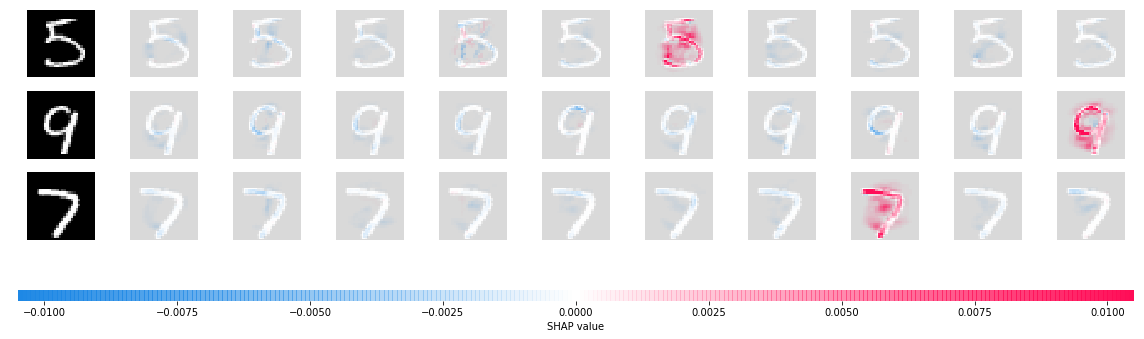

In [0]:
# 테스트 입력 영상 데이터에 대한 Shap value 계산
test_sample = x_test[15:18]
shap_values = explainer.shap_values(test_sample)

# 입력 데이터 공헌도 시각화
shap.image_plot(shap_values, test_sample)

## KernelExplainer

### Iris classification with sklearn


In [0]:
!pip install shap

In [0]:
# 사용할 모듈 불러오기
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import shap

In [0]:
# Iris 데이터 불러오기
d = sklearn.datasets.load_iris()
df = pd.DataFrame(data=d.data, columns=d.feature_names)

In [0]:
df

In [80]:
print(d.target_names)
print(d.target)

['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [0]:
# 훈련셋과 테스트셋으로 분리
X_train,X_test,Y_train,Y_test = train_test_split(df, d.target,
                                                 test_size=0.2, random_state=0)

In [0]:
# 분류기 모델 정의
classifier = sklearn.linear_model.LogisticRegression()

In [84]:
# 분류기 모델 학습
classifier.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
# 분류 정확도 출력
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))

print_accuracy(classifier.predict)

Accuracy = 96.66666666666667%


In [0]:
# 설명 모델 생성
explainer = shap.KernelExplainer(classifier.predict_proba, X_train)

In [101]:
# shapley value 계산
test_sample = X_test[0:1]
shap_values = explainer.shap_values(test_sample)

# shapley value 시각화
shap.initjs()
classNumber = 0 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

/usr/local/lib/python3.6/dist-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \


In [103]:
shap.initjs()
classNumber = 1 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

In [104]:
shap.initjs()
classNumber = 2 # 0: setosa / 1: versicolor / 2: virginica
shap.force_plot(explainer.expected_value[classNumber], 
                shap_values[classNumber], test_sample)

In [0]:
Y_test

In [0]:
X_test

## TreeExplainer

### boston house prices regression with xgboost

In [0]:
# 사용할 모듈 불러오기
import xgboost
import pandas as pd
import shap

In [0]:
# boston 데이터 불러오기
d = sklearn.datasets.load_boston()
df = pd.DataFrame(data=d.data, columns=d.feature_names)
X = df
y = d.target

In [124]:
X.shape

(506, 13)

In [125]:
y.shape

(506,)

In [127]:
X.head(1)

CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO      B  LSTAT
0  0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.9   4.98

[1 rows x 13 columns]

특징 데이터 X:
- CRIM: 범죄율
- INDUS: 비소매상업지역 면적 비율
- NOX: 일산화질소 농도
- RM: 주택당 방 수
- LSTAT: 인구 중 하위 계층 비율
- B: 인구 중 흑인 비율
- PTRATIO: 학생/교사 비율
- ZN: 25,000 평방피트를 초과 거주지역 비율
- CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
- AGE: 1940년 이전에 건축된 주택의 비율
- RAD: 방사형 고속도로까지의 거리
- DIS: 직업센터의 거리
- TAX: 재산세율

In [130]:
y[0:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

타겟 데이터 y:
- 1978 보스턴 주택 가격
- 506개 타운의 주택 가격 중앙값 (단위 1,000 달러)

In [0]:
# 예측 모델 학습(XGBoost)
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [0]:
# 설명 모델 생성
explainer = shap.TreeExplainer(model)
# shapley value 계산
shap_values = explainer.shap_values(X)

In [142]:
# 하나의 데이터에 대해 shapley value 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [143]:
# 학습 데이터 전체에 대해 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

## 3) 적용하기: SHAP 활용
### Red Wine Quality
#### Classification with XGBClassifier

In [0]:
## 사용할 모듈 불러오기
# 연산 모듈
import pandas as pd
import numpy as np
# 시각화 모듈
import matplotlib.pyplot as plt
import seaborn as sns 
# 데이터 처리 모듈
from sklearn.model_selection import train_test_split
# 행렬 연산 모듈
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
# xgboost 모델 모듈
from xgboost import XGBClassifier, plot_importance
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')
# 그래프 스타일 설정
plt.style.use('fivethirtyeight')
%matplotlib inline

In [0]:
# csv 파일 레드 와인 데이터 불러오기
wines = pd.read_csv('/content/drive/My Drive/PyConKorea2019-Tutorials/SHAP/winequality-red.csv')

In [173]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [151]:
wines.shape

(1599, 12)

특징 데이터:
- fixed acidity: 고정 산도
- volatile acidity: 휘발성 산도
- citric acid: 구연산
- residual sugar: 자연 발효로 생성된 당분
- chlorides: 염소
- free sulfur dioxide: 유황 이산화황
- total sulfur dioxide: 총 이산화황
- density: 밀도
- pH
- sulphates: 황산염
- alcohol: 알코올
- quality (score between 0 and 10): 품질(0~10점)

In [154]:
# 레드 와인 데이터 중 의미 있는 feature 목록으로 만들기 위해 데이터 전처리
target = 'quality' # # Extracting our target variable 
features_list = list(wines.columns)
features_list.remove(target) # # and creating a usefull feature list of dependant variables
y = wines.pop('quality') # # create our separate target vector
y = y.apply(lambda x: 0 if x <= 5 else 1) # mapping the target to a binary class at quality = 5
y.sum() / len(y) # quickly check that we have a balanced target partition

0.5347091932457786

In [155]:
# 훈련 셋과 테스트 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(wines, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

In [157]:
# xgboost 분류기 생성
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

# xgboost 분류기 학습
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [161]:
# 분류율 평가 함수
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)
    
# 학습 모델 성능 평가
xgb_predictions = xgb.predict(X_test)
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.7521
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.74      0.73      0.73       226
Hight Quality       0.76      0.77      0.77       254

     accuracy                           0.75       480
    macro avg       0.75      0.75      0.75       480
 weighted avg       0.75      0.75      0.75       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        165   61
        1         58  196


In [0]:
# 설명 모델 생성
explainer = shap.TreeExplainer(xgb)
# shapley value 계산
shap_values = explainer.shap_values(X_test)

### Predicting when a particular wine quality will be <= 5 ('Low Quality')

In [163]:
# 테스트 데이터 1개 샘플로 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

### Predicting when a particular wine quality will be > 5 ('Hight Quality')

In [164]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

### Visualizing and explaining multiple predictions

In [165]:
# 테스트 데이터 여러 샘플로 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

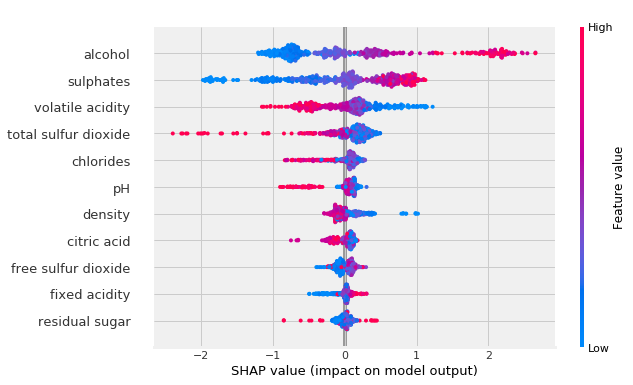

In [166]:
# 입력 feature 요약
shap.initjs()
shap.summary_plot(shap_values, X_test)